In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Manual Separation by NumPy

In [2]:
iris_data = sns.load_dataset('iris')

data_tensor = torch.tensor(iris_data[iris_data.columns[:4]].values).float()
label_tensor = torch.zeros(len(iris_data), dtype=torch.long)
label_tensor[iris_data.species == 'versicolor'] = 1
label_tensor[iris_data.species == 'virginica'] = 2

In [3]:
prop_train = 0.8
num_train = int(len(label_tensor)*prop_train)

train_test_bool = np.zeros(len(label_tensor), dtype=bool)

train_test_bool[np.random.choice(range(len(label_tensor)), num_train, replace=False)] = True
print(train_test_bool)

[ True  True  True  True  True  True False  True False  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True False  True False  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True False  True
  True  True  True False False  True False  True  True  True  True  True
  True  True  True  True  True False  True  True False  True  True False
 False  True  True False  True  True False  True  True  True  True False
  True  True  True  True  True  True False  True False False False  True
 False  True  True False  True  True  True  True False  True  True  True
  True  True  True  True  True  True False  True  True  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True False]


In [4]:
print(torch.mean(label_tensor.float()), label_tensor.shape, data_tensor.shape)

print(torch.mean(label_tensor[train_test_bool].float()), label_tensor[train_test_bool].shape, data_tensor[train_test_bool].shape)

print(torch.mean(label_tensor[~train_test_bool].float()), label_tensor[~train_test_bool].shape, data_tensor[~train_test_bool].shape)

tensor(1.) torch.Size([150]) torch.Size([150, 4])
tensor(0.9500) torch.Size([120]) torch.Size([120, 4])
tensor(1.2000) torch.Size([30]) torch.Size([30, 4])


In [5]:
ann_iris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))

loss_fun = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)

In [6]:
num_epochs = 1500

losses = torch.zeros(num_epochs)
ongoing_acc = []

for epoch in range(num_epochs):
    y_hat = ann_iris(data_tensor[train_test_bool])
    
    loss = loss_fun(y_hat, label_tensor[train_test_bool])
    losses[epoch] = loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ongoing_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == label_tensor[train_test_bool]).float()))

In [7]:
train_predictions = ann_iris(data_tensor[train_test_bool])
train_acc = 100*torch.mean((torch.argmax(train_predictions, axis=1) == label_tensor[train_test_bool]).float())

test_predictions = ann_iris(data_tensor[~train_test_bool])
test_acc = 100*torch.mean((torch.argmax(test_predictions, axis=1) == label_tensor[~train_test_bool]).float())

print("Train Accuracy = %g%%" %train_acc)
print("Test Accuracy = %g%%" %test_acc)

Train Accuracy = 98.3333%
Test Accuracy = 93.3333%


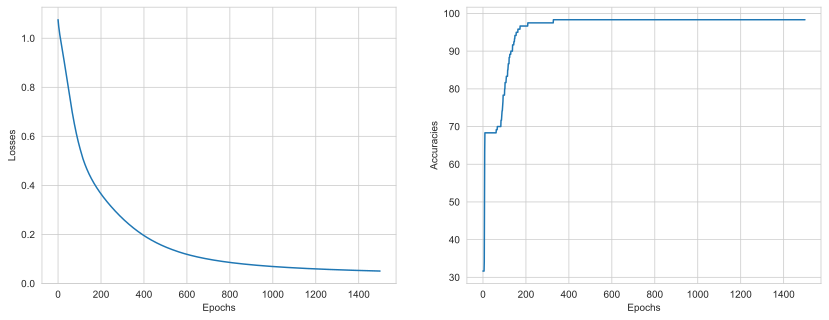

In [8]:
_, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(losses.detach())
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Losses")

axis[1].plot(ongoing_acc)
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracies");

# Separation by Scikit-Learn

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def ann_iris_model():
    ann_iris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)
    
    return ann_iris, loss_fun, optimizer

In [11]:
num_epochs = 500

def train_model(prop_train):
    
    losses = torch.zeros(num_epochs)
    
    train_acc = []
    test_acc = []

    x_train, x_test, y_train, y_test = train_test_split(data_tensor, label_tensor, train_size=prop_train)
    
    for epoch in range(num_epochs):
        y_hat = ann_iris(x_train)
        
        loss = loss_fun(y_hat, y_train)
        losses[epoch] = loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y_train).float()).item())
        
        test_acc.append(100*torch.mean((torch.argmax(ann_iris(x_test), axis=1) == y_test).float()).item())
        
    return train_acc, test_acc

In [12]:
ann_iris, loss_fun, optimizer = ann_iris_model()
train_acc, test_acc = train_model(0.8)

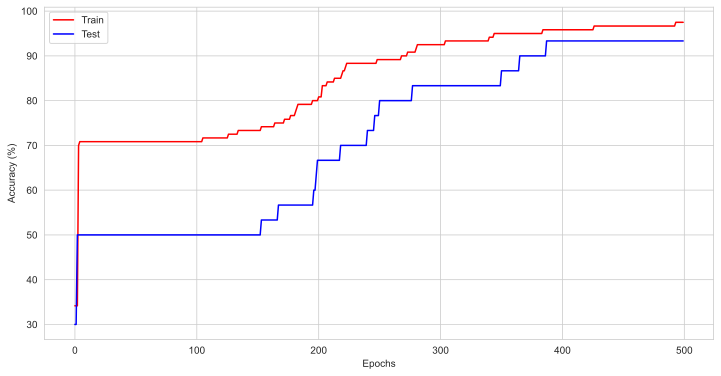

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, 'r')
plt.plot(test_acc, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);

In [14]:
train_set_sizes = np.linspace(0.2, 0.95, 10)

all_train_acc = np.zeros((len(train_set_sizes), num_epochs))
all_test_acc = np.zeros((len(train_set_sizes), num_epochs))

for i in range(len(train_set_sizes)):
    ann_iris, loss_fun, optimizer = ann_iris_model()
    train_acc, test_acc = train_model(train_set_sizes[i])
    all_train_acc[i] = train_acc
    all_test_acc[i] = test_acc

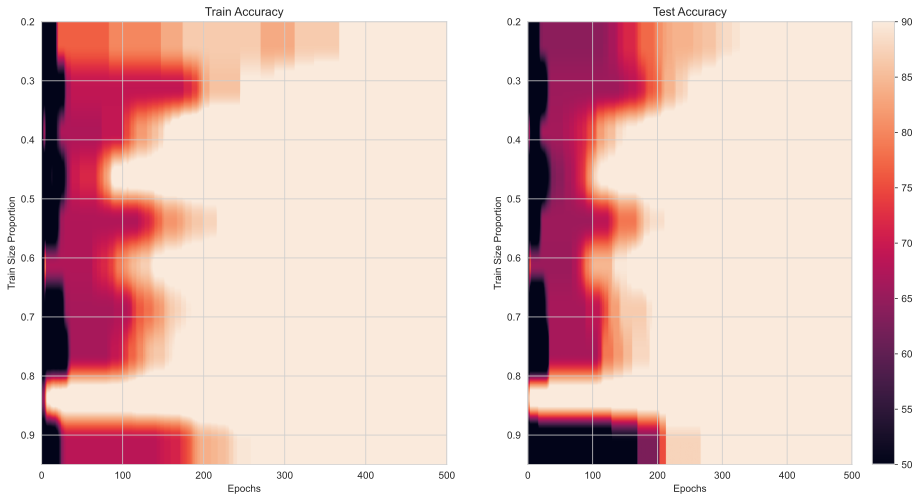

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(16, 8))
axis[0].imshow(all_train_acc, aspect='auto', vmin=50, vmax=90, extent=[0, num_epochs, train_set_sizes[-1], train_set_sizes[0]])
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Train Size Proportion")
axis[0].set_title("Train Accuracy")

plot = axis[1].imshow(all_test_acc, aspect='auto', vmin=50, vmax=90, extent=[0, num_epochs, train_set_sizes[-1], train_set_sizes[0]])
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Train Size Proportion")
axis[1].set_title("Test Accuracy")
fig.colorbar(plot, ax=axis[1]);

# Separation by PyTorch DataLoader

In [16]:
from torch.utils.data import DataLoader, TensorDataset

In [17]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, label_tensor, train_size=0.8)

train_data = TensorDataset(train_data, train_labels)

test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [18]:
def ann_iris_model():
    ann_iris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ann_iris.parameters(), lr=0.01)

    return ann_iris, loss_fun, optimizer

In [19]:
num_epochs = 500

def train_model():
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        batch_acc = []
        for x, y in train_loader:
            y_hat = ann_iris(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        train_acc.append(np.mean(batch_acc))
        
        x, y = next(iter(test_loader))
        test_acc.append(100*torch.mean((torch.argmax(ann_iris(x), axis = 1) == y).float()).item())
        
    return train_acc, test_acc   

In [20]:
train_acc, test_acc = train_model()

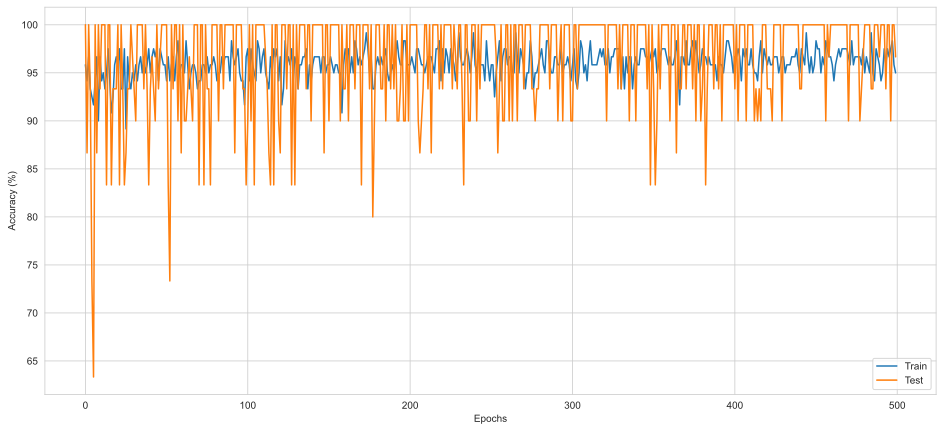

In [21]:
plt.figure(figsize=(16, 7))
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.legend(["Train", "Test"])
plt.ylabel("Accuracy (%)");

# Separation on Regression

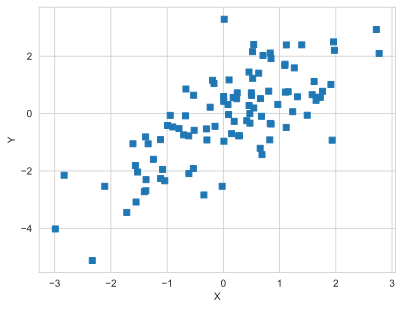

In [22]:
n = 100
x = torch.randn(n, 1)
y = x + torch.randn(n, 1)

plt.plot(x, y, 's')
plt.xlabel('X')
plt.ylabel('Y');

In [23]:
ann_reg = nn.Sequential(nn.Linear(1, 1), nn.ReLU(), nn.Linear(1, 1))

loss_fun = nn.MSELoss()

optimizer = torch.optim.SGD(ann_reg.parameters(), lr = 0.05)

In [24]:
train_index = np.random.choice(range(n), 80, replace=False)
train_bool = np.zeros(n, dtype=bool)
train_bool[train_index] = True

print(x[train_bool].shape)
print(x[~train_bool].shape)

torch.Size([80, 1])
torch.Size([20, 1])


In [25]:
num_epochs = 500

for epoch in range(num_epochs):
    y_hat = ann_reg(x[train_bool])
    
    loss = loss_fun(y_hat, y[train_bool])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [26]:
predictions = ann_reg(x[~train_bool])
test_loss = (predictions - y[~train_bool]).pow(2).mean()

print(f"Final Training Loss - {loss.detach():.2f}")
print(f"Final Testing Loss - {test_loss.detach():.2f}")

Final Training Loss - 1.15
Final Testing Loss - 1.17


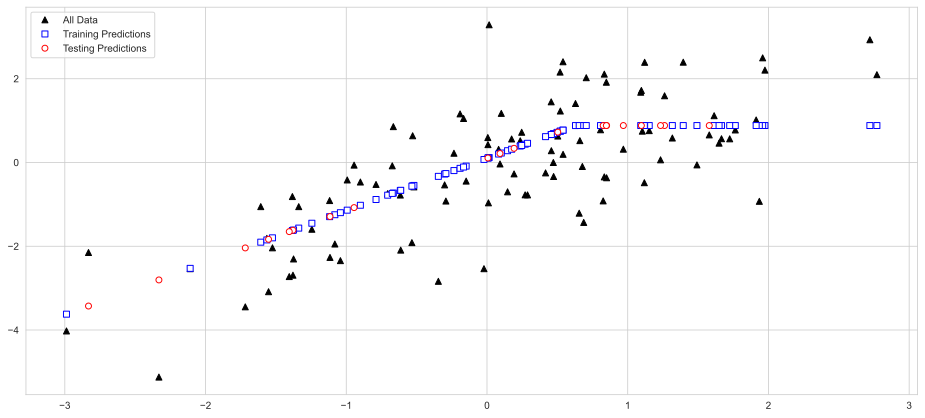

In [27]:
pred_ytrain = ann_reg(x[train_bool]).detach().numpy()

plt.figure(figsize=(16, 7))
plt.plot(x, y, 'k^', label="All Data")
plt.plot(x[train_bool], pred_ytrain, 'bs', markerfacecolor='w', label="Training Predictions")
plt.plot(x[~train_bool], predictions.detach(), 'ro', markerfacecolor='w', label="Testing Predictions")
plt.legend();